Assignment: Flowers Recognition <br>
Dataset Description:<br>

This dataset contains 4242 images of flowers.<br>
The data collection is based on the data flicr, google images, yandex images.<br>
You can use this datastet to recognize plants from the photo.<br>

Attribute Information:<br>
The pictures are divided into five classes: 0daisy, 1tulip, 2rose, 3sunflower, 4dandelion.<br>
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. <br>
<b>Also explore how to resize images in tensorflow and then resize all the images to a same size. </b> <br>
This is a Multiclass Classification Problem.<br>



WORKFLOW : <br>
Load Data <br>
Split into 60 and 40 ratio.<br>
Encode labels.<br>
Create Model<br>
Compilation Step (Note : Its a Multiclass Classification problem , select loss , metrics according to it)<br>
Train the Model.<br>
If the model gets overfit tune your model by changing the units , No. of layers , epochs , add dropout layer or add Regularizer according to the need .<br>
Prediction should be > 85%<br>
Evaluation Step<br>
Prediction<br>




1Load Data

Data : <br>
https://drive.google.com/file/d/1-OX6wn5gA-bJpjPNfSyaYQLz-A-AB_uj/view?usp=sharing

In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
#from fastai.basics import *
#import random
import sys
import time
import cv2
import numpy as np
import tensorflow as tf
import os
import zipfile
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

2.4.1


In [4]:
sys.version

'3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]'

extract files from zip file

In [5]:
zip_ref = zipfile.ZipFile('drive/My Drive/Colab Notebooks/Q2Assignments/flowers.zip', 'r')
zip_ref.extractall('unzipped_folder') # unzip directory
zip_ref.close()

In [6]:
base_path = 'unzipped_folder/flowers/'
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

load images

In [7]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [8]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [769, 1055, 784, 734, 984]


Loading images

In [9]:
# train, test = train_test_split(fnames[0], train_size=0.8)
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [10]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [769, 1052, 784, 734, 984]


Minimum shape of all images

In [11]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

125,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip


convert cv2 BGR format to RGB

In [12]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

sample images for all flowers

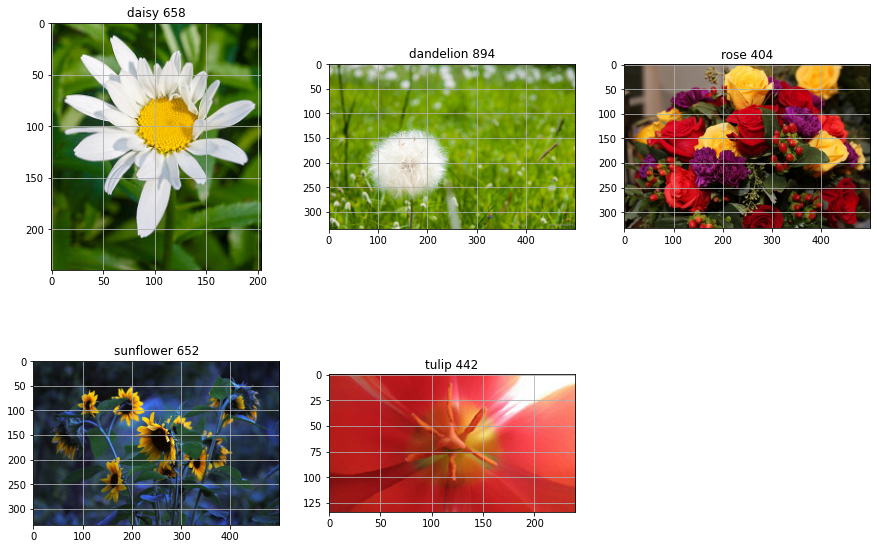

In [13]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

Resize all the images to 320x240

(240, 320, 3)
(320, 240, 3)


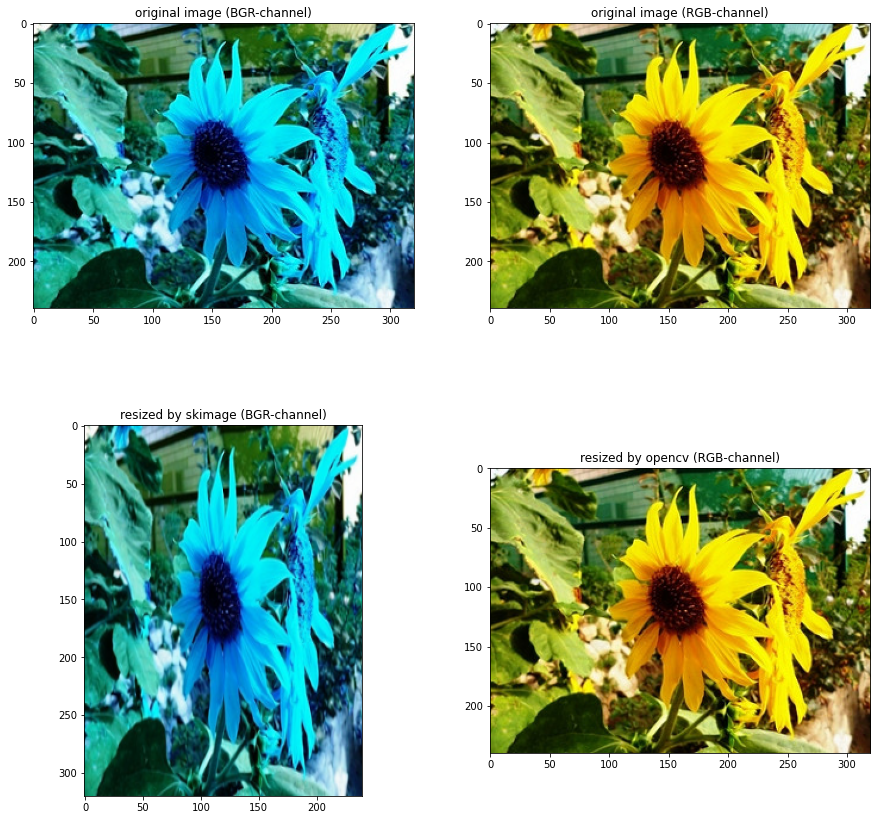

In [15]:
img_width, img_height = 320, 240 ##

img = images[3][659]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [16]:
# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

2Split dataset to 60% of training and 40% of validation

In [17]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.6, test_size=0.4)
    train_images.append(train)
    val_images.append(test)

3Creat labels

In [18]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[461, 631, 470, 440, 590]
sum of train images: 2592
[308, 421, 314, 294, 394]
sum of val_images: 1731


Convert image data to numpy array
Convert and pre-processing
convert class labels to binary class labels

In [19]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [20]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (2592, 240, 320, 3)
train labels: (2592,)

After converting
train data: (2592, 240, 320, 3)
train labels: (2592, 5)


Shuffle the dataset (set a seed and randomize both the data and the labels)

In [21]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [22]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (2592, 240, 320, 3)
shape of train labels: (2592, 5)
shape of val data: (860, 240, 320, 3)
shape of val labels: (860, 5)


Model

In [24]:
from tensorflow.keras import models
from tensorflow.keras import layers
model=models.Sequential()
model.add(layers.Dense(20,activation='relu',input_shape=(train_data.shape[1],)))
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(8,activation='relu'))
model.add(layers.Dense(6,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

Compilation

In [26]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

Train the model

In [ ]:
history=model.fit(train_data,train_labels,epochs=2,batch_size=32)

Predict

In [ ]:
x=model.predict(train_data).astype(dtype='uint8')
x

Evaluation

Prediction